Epoch 1/10
--------------------
Loss: 0.3943 Acc: 0.8676
Epoch 2/10
--------------------
Loss: 0.1560 Acc: 0.9409
Epoch 3/10
--------------------
Loss: 0.0982 Acc: 0.9796
Epoch 4/10
--------------------
Loss: 0.0983 Acc: 0.9633
Epoch 5/10
--------------------
Loss: 0.1035 Acc: 0.9572
Epoch 6/10
--------------------
Loss: 0.1380 Acc: 0.9470
Epoch 7/10
--------------------
Loss: 0.0746 Acc: 0.9796
Epoch 8/10
--------------------
Loss: 0.0758 Acc: 0.9735
Epoch 9/10
--------------------
Loss: 0.0681 Acc: 0.9674
Epoch 10/10
--------------------
Loss: 0.0608 Acc: 0.9796
Model saved to cataract_model.pth

Classification Report:
              precision    recall  f1-score   support

    cataract       1.00      0.93      0.97        61
      normal       0.94      1.00      0.97        60

    accuracy                           0.97       121
   macro avg       0.97      0.97      0.97       121
weighted avg       0.97      0.97      0.97       121



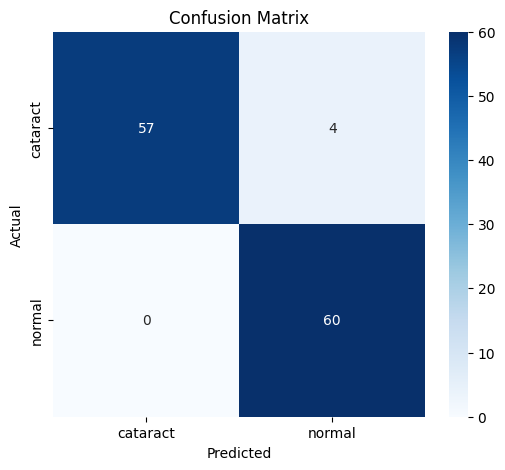

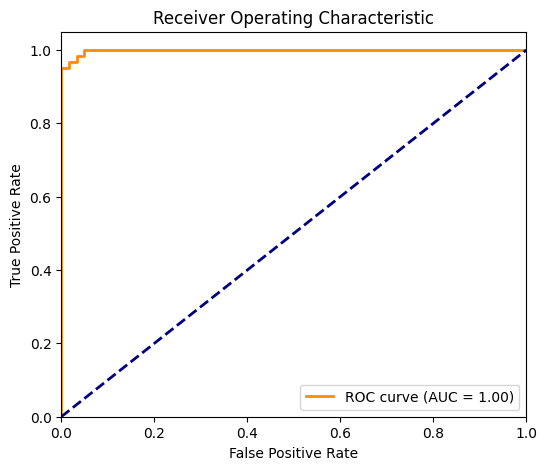

In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Paths
data_dir = r'D:\raj\catract detection\processed_images'
model_save_path = 'cataract_model.pth'

# Parameters
batch_size = 16
input_size = 224
epochs = 10  # Increased epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Load Datasets
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'test']
}

# Data Loaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ['train', 'test']
}

# Class names
class_names = ['cataract', 'normal']

# Model setup
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}\n{"-"*20}')
    model.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloaders['train'].dataset)
    epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)

    print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# Save the trained model
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

# Evaluation function
def evaluate_model(model):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of class 1 ('normal')
            _, preds = torch.max(outputs, 1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    unique_labels = np.unique(all_labels)
    used_class_names = [class_names[label] for label in unique_labels]

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=used_class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=used_class_names,
                yticklabels=used_class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # ROC Curve (only if binary classification)
    if len(unique_labels) == 2:
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

# Run evaluation
evaluate_model(model)
